## Do H' and lambda pods
__NB:__ `conda install -c r rpy2=2.8.6 -f`
rpy2 needs to be a specific version to work in the ipython notebook.

In [4]:
%matplotlib inline
%load_ext rpy2.ipython

import os

GIMME_DIR = "/home/isaac/gimmeSAD/"
os.chdir(GIMME_DIR)
SIMOUT_DIR = GIMME_DIR + "1d_sims/"

import gimmeSAD
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import itertools
import random
import glob

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
def get_stats(tr, est):
    tr = np.array(tr).flatten()

    rms = sqrt(mean_squared_error(tr, est))
    r = np.corrcoef(np.vstack((tr, est)))[1,0]

    return rms, r

## Gather all the simulations into one huge simout file

In [5]:
REF_TABLE = os.path.join(SIMOUT_DIR, "priors.txt")
outfile = open(REF_TABLE, "w")

ONEPER = False
REGULARIZE = False
DROPEQUILIBSIMS = True

files = glob.glob(SIMOUT_DIR + "*/sumstats.txt")
numsims = 0
outfile.write(open(files[0]).readlines()[0])
for f in files:
    lines = open(f).readlines()[1:]
    new_lines = []
    for line in lines:
        try:
            ## DO or don't regularlize the histograms
            if REGULARIZE:
                hist = np.array([int(x) for x in line.split()[7:]])
                if np.sum(hist):
                    tot = np.sum(hist)
                    hist = hist/float(tot)
                tmp = line.split()[:7] + map(str,hist)
                line = " ".join(tmp) + "\n"
                new_lines.append(line)

            ## Do or don't drop all the extra sims at equilibrium
            if line.split()[3] == "1" and DROPEQUILIBSIMS:
                pass
            else:
                new_lines.append(line)
        except:
            pass
    lines = new_lines
    ## Only choose one step per simulation?
    if lines and ONEPER:
        lines = [random.choice(lines)]
    ## Don't write blanks
    if lines:
        numsims += len(lines)
        outfile.write("".join(lines))
        outfile.write("\n")
outfile.close()

print("Processed {} simulations.".format(numsims))

Processed 920663 simulations.


## Do the abc in R cuz python abc packages suck
https://www.datacamp.com/community/blog/jupyter-notebook-r#gs.CkjgxoE

## Load the data into R

In [6]:
%%R -i REF_TABLE
## Have to install the abc package the first time
##install.packages("abc")
library(abc)

## fill adds NA for any incomplete row
PRIOR <- read.table(REF_TABLE, header=TRUE, fill=TRUE)
print(PRIOR[1,])


/home/isaac/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: abc.data

  warnings.warn(x, RRuntimeWarning)
/home/isaac/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: nnet

  warnings.warn(x, RRuntimeWarning)
/home/isaac/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: quantreg

  warnings.warn(x, RRuntimeWarning)
/home/isaac/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: SparseM

  warnings.warn(x, RRuntimeWarning)
/home/isaac/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘SparseM’


  warnings.warn(x, RRuntimeWarning)
/home/isaac/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following object is masked from ‘packag

     K         c  step    X.equil colrate extrate  shannon bin_0 bin_1 bin_2
1 4606 0.0277614 10000 0.05579679  0.0279   0.007 1.689744    55    34     4
  bin_3 bin_4 bin_5 bin_6 bin_7 bin_8 bin_9
1     2     2     1     1     0     0     1


In [7]:
paramsdict = {"K":1, "c":2, "X.equil":4, "colrate":5, "extrate":6, "shannon":7, "SGD":range(8,18)}
print(paramsdict)

{'c': 2, 'K': 1, 'SGD': [8, 9, 10, 11, 12, 13, 14, 15, 16, 17], 'extrate': 6, 'X.equil': 4, 'shannon': 7, 'colrate': 5}


# Scenario M(A) - H'

## Λ PODS

Prediction error based on a cross-validation sample of 100

            eq
0.01 0.1515508
0.05 0.1513108


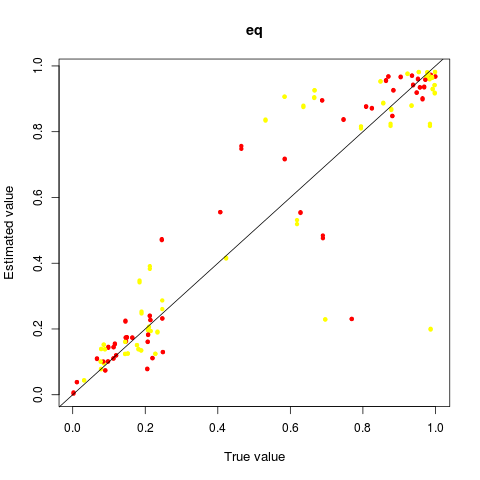

In [8]:
%%R -o tr,est

cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,7], nval=100, tols=c(.01, .05), method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

## Return true and estimated values
tr <- cv.res.reg$true
est <- cv.res.reg$estim$tol0.01

In [85]:
print("RMS, R")
rms, r = get_stats(tr,est)
print(rms, str(r**2))

RMS, R
(0.35772933642857757, '0.662116863409')


Prediction error based on a cross-validation sample of 100

            eq
0.01 1.0112240
0.05 0.9659694
0.5  1.0016930


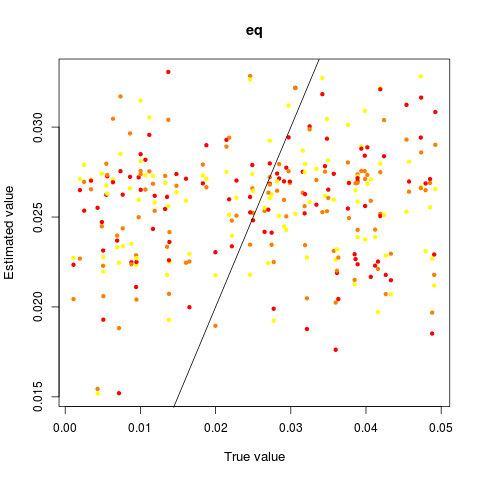

In [79]:
%%R -o tr,est
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"colrate"]), PRIOR[,7], nval=100, tols=c(.01, .05, 0.5), method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)
## Return true and estimated values
tr <- cv.res.reg$true
est <- cv.res.reg$estim$tol0.01

In [81]:
print("RMS, R")
print(get_stats(tr,est))

RMS, R
(0.014266108695060117, 0.10371360948162638)
100


# Scenario M(I) - 1D SGD
## Estimate H' using 1D π vector

Prediction error based on a cross-validation sample of 100

          shan
0.01 0.3708533
0.05 0.3436223


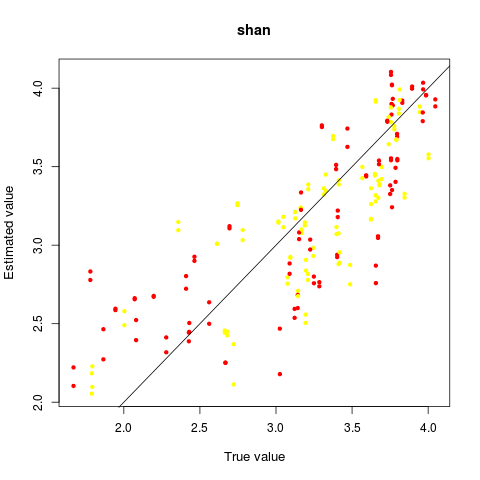

In [82]:
%%R -o tr,est
cv.res.reg <- cv4abc(data.frame(shan=PRIOR[,"shannon"]), PRIOR[,8:17],
                     nval=100, tols=c(.01, .05), method="loclinear", 
                     statistic="median")
print(summary(cv.res.reg))
plot(cv.res.reg)
## Return true and estimated values
tr <- cv.res.reg$true
est <- cv.res.reg$estim$tol0.05

In [84]:
print("RMS, R")
rms, r = get_stats(tr,est)
print(rms, str(r**2))

RMS, R
(0.35772933642857757, '0.662116863409')


## Estimate Λ using 1D π pi vector

Prediction error based on a cross-validation sample of 100

            eq
0.01 0.5692685
0.05 0.5233106


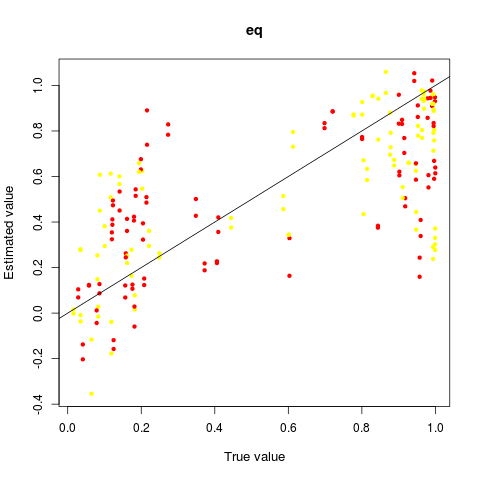

In [86]:
%%R -o tr,est
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,8:17], 
                     nval=100, tols=c(.01, .05), method="loclinear", 
                     statistic="median")
print(summary(cv.res.reg))
plot(cv.res.reg)
## Return true and estimated values
tr <- cv.res.reg$true
est <- cv.res.reg$estim$tol0.05

In [87]:
print("RMS, R")
rms, r = get_stats(tr,est)
print(rms, str(r**2))

RMS, R
(0.27659035794536746, '0.503971465752')


## Estimate colonization rate from SGD

Prediction error based on a cross-validation sample of 100

            eq
0.01 0.4276709
0.05 0.2911562


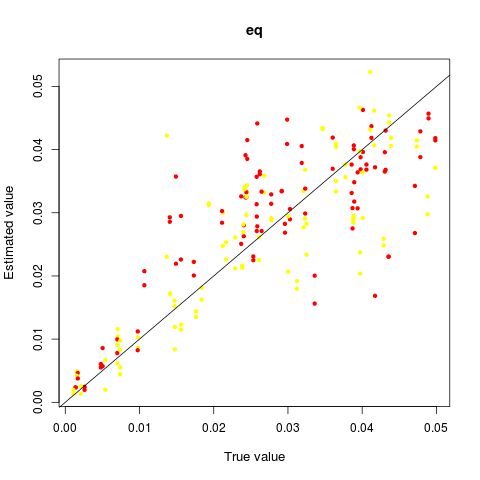

In [19]:
%%R
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"colrate"]), PRIOR[,8:17], 
                     nval=100, tols=c(.01, .05), method="loclinear", 
                     statistic="median")
print(summary(cv.res.reg))
plot(cv.res.reg)

# Scenario M(AI) - 1D SGD & H'
## Estimate Λ using 1D π vector and Shannon's Index

Prediction error based on a cross-validation sample of 50

            eq
0.01 0.1050862
0.05 0.1169718
0.5  0.1471389


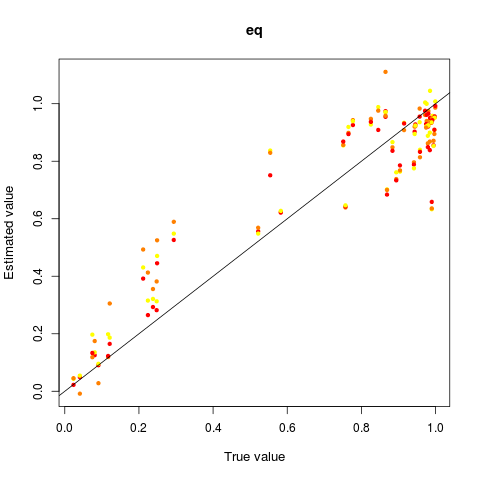

In [45]:
%%R
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,7:17], 
                     nval=50, tols=c(.01, .05, 0.5), method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

## Estimate colonization rate using shannon index and 1d pi vector

Prediction error based on a cross-validation sample of 20

            eq
0.01 0.1736363
0.05 0.1911525
0.5  0.2322665


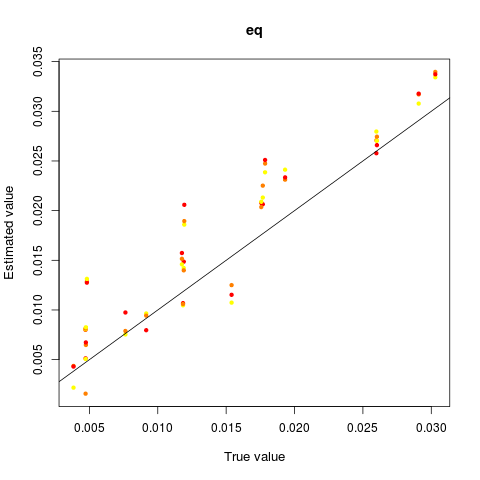

In [21]:
%%R
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"colrate"]), PRIOR[,7:17], nval=20, tols=c(.01, .05, 0.5), method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

## Estimate island size using shannon and 1d pi vector

Prediction error based on a cross-validation sample of 50

             eq
0.001 0.6453266
0.005 0.3867152
0.01  0.3609488
0.05  0.3812574
0.1   0.3750593


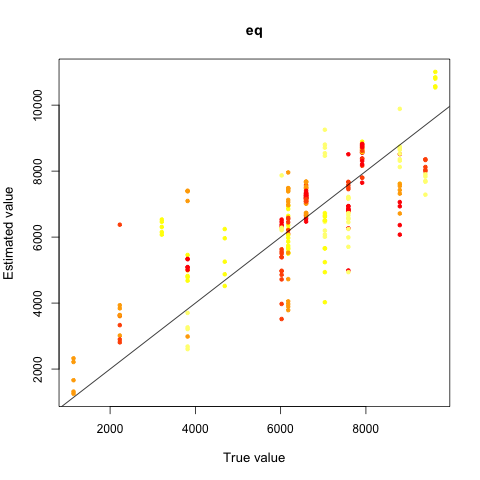

In [74]:
%%R
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"K"]), PRIOR[,7:17], nval=50, tols=c(.001, .005, .01, .05,.1), method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

# Co-estimate island size and %equil 

## Estimate island size/%equil using shannon and 1d pi vector

In [ ]:
%%R
cv.res.reg <- cv4abc(data.frame(k=PRIOR[,"K"], eq=PRIOR[,"X.equil"]), PRIOR[,7:17], nval=50, tols=c(.001, .005, .01, .05,.1), method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

# Scenario M(MI) - 2D SGD

# Scenario M(AMI) - 2D SGD & H'

# Trash below here

In [50]:
%%R -o tr,est
#cv.res.reg$true
tr <- cv.res.reg$true
est <- cv.res.reg$estim$tol0.01

In [64]:
from sklearn.metrics import mean_squared_error
from math import sqrt
tr = np.array(tr).flatten()

rms = sqrt(mean_squared_error(tr, est))
print(rms)
r = np.corrcoef(np.vstack((tr, est)))[1,0]
print(r)

0.0137634379473
0.0959646255565


### Neuralnet (slow)

12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
12345678910
Prediction error based on a cross-valida

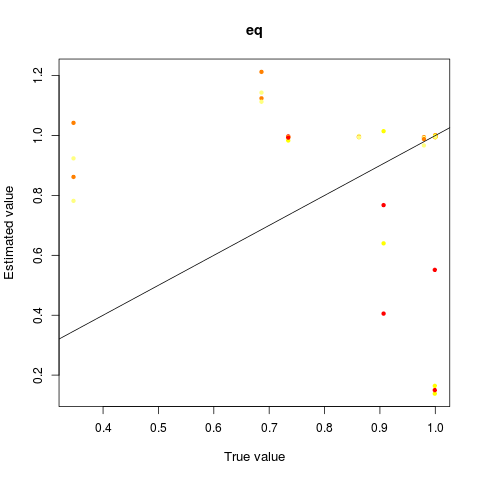

In [23]:
%%R
## This is slow even on toy data
cv.res.net <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,7:17], nval=10, tols=c(.01, .05,.1, 0.5), method="neuralnet")
print(summary(cv.res.net))
plot(cv.res.net)

In [27]:
dat = open("new_sims/priors.txt").readlines()
outfile = open("new_sims/newpriors.txt", 'w')
outfile.write(dat[0])
count = 0
for line in dat[1:]:
    try:
        if len(line) ==1:
                count += 1
        elif not line.strip().split()[3] == "1":
                outfile.write(line)
    except:
        pass
print("how many blanks {}".format(count))

how many blanks 508


In [62]:
import math
def shannon(abundances):
    ## Unpack the abundance dist
    abunds = [v for v in abundances.values()]
    tot = np.sum(abunds)
    return -1 * np.sum([x/float(tot) * math.log(x/float(tot)) for x in abunds  if x > 0])

In [78]:
#8   25  7   4   1   3   2   4   1   2
wat = {1:8, 2:25, 3:7, 5:4, 6:1, 7:3, 8:2, 9:4, 10:1, 11:2}
shannon(wat)

[8, 25, 7, 4, 1, 3, 2, 4, 1, 2]
57


1.7994095226462321

In [30]:
%%R
summary(cv.res.net)
cv.res.net + cv.res.net

Prediction error based on a cross-validation sample of 10
Error in cv.res.net + cv.res.net : 
  non-numeric argument to binary operator


/home/isaac/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in cv.res.net + cv.res.net : 
  non-numeric argument to binary operator

  warnings.warn(x, RRuntimeWarning)
